In [1]:
# @title
# Install MNE library (if not already installed)
!pip install mne

# Import necessary libraries
import numpy as np
import scipy.io
import mne
import matplotlib.pyplot as plt
from google.colab import drive



# 1. Mount Google Drive
# Mount Google Drive to access the dataset.
# (Example: drive.mount('/content/drive'))

# 2. Load the Data
# Load the '.mat' file using scipy.io.loadmat.
# (Example: file_path = '/content/drive/My Drive/eea/Dataset/Subject_A_Train.mat'; mat_data = scipy.io.loadmat(file_path))

# 3. Extract & Reshape EEG Signal
# The raw signal is typically 3D (Epochs, Samples, Channels).
# Reshape it into 2D (Channels, Total_Samples) for MNE.
# This involves concatenating epochs and transposing the data.
# Convert the units from microvolts (uV) to Volts (V).

# 4. Process Marker Channels (e.g., Flashing & StimulusCode)
# These markers are usually 3D or 2D and need to be flattened to 1D to match the continuous signal length.
# Ensure the lengths of the processed signal and markers are consistent.

# 5. Construct MNE Events
# Using the processed marker channels (e.g., 'Flashing' for onset detection and 'StimulusCode' for event IDs),
# detect event onsets (e.g., rising edges of the 'Flashing' signal).
# Then, create an MNE-compatible events array: (onset_index, 0, event_id).

# 6. Create MNE Raw Object
# Define the sampling frequency (sfreq), channel names (ch_names), and channel types (ch_types).
# Then, create an MNE 'info' object.
# Finally, create an 'mne.io.RawArray' object from the reshaped EEG signal and the 'info' object.
# Optionally, add the events as a 'stim' channel to the raw object.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 87.6 MB/s eta 0:00:00


In [ ]:
#1)First unzipping provided dataset
drive.mount('/content/drive')
zip_path = "/content/drive/My Drive/Copy of BCI_Comp_III_Wads_2004.zip"
extract_path = "/content/eeg_data"
!unzip -q "$zip_path" -d "$extract_path"

In [27]:
#2)Loading data
file_path = "/content/eeg_data/BCI_Comp_III_Wads_2004/Subject_A_Train.mat"
mat_data = scipy.io.loadmat(file_path)
print(mat_data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'Signal', 'TargetChar', 'Flashing', 'StimulusCode', 'StimulusType'])


In [28]:
#3)Extracting and Reshaping signal:

signal=mat_data['Signal']
#Concatenating and transposing:
signal_concat=np.concatenate(signal,axis=0)
eeg_data=signal_concat.T
#Converting uV to V
eeg_data=eeg_data*1e-6


In [29]:
#4)Processing marker channesl:

flashing=mat_data['Flashing']
stimulus_code=mat_data['StimulusCode']

flashing_concat=np.concatenate(flashing,axis=0)
stimulus_code_concat=np.concatenate(stimulus_code,axis=0)

#Now flattening to 1-d
flashing_flat=flashing_concat.flatten()
stimulus_code_flat=stimulus_code_concat.flatten()

print(flashing_flat.shape)
print(stimulus_code_flat.shape)
print(eeg_data.shape)

#As we can see the number of samples do match

(662490,)
(662490,)
(64, 662490)


In [30]:
#5)Constructing MNE events:

#Detecting rising edges, we do +1 since we want idx where the flash becomes 1
onsets=np.where(np.diff(flashing_flat)==1)[0]+1
event_ids=stimulus_code_flat[onsets]

#Construct MNE-compatible events array
events=np.column_stack((onsets,np.zeros(len(onsets),dtype=int),event_ids))

print(events.shape)

(15299, 3)


In [31]:
#6)Creating MNE raw object:

sfreq=240 #Since This dataset has sfreq as 240hz
n_channels=eeg_data.shape[0]

ch_names=[f'Channel_{i+1}' for i in range(n_channels)]
ch_types=['eeg']*n_channels

info=mne.create_info(ch_names,sfreq,ch_types)
raw=mne.io.RawArray(eeg_data,info)

Creating RawArray with float64 data, n_channels=64, n_times=662490
    Range : 0 ... 662489 =      0.000 ...  2760.371 secs
Ready.


In [ ]:
## https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html#

# 1. Visualize Data BEFORE Filtering (Power Spectral Density)
# Compute and plot the Power Spectral Density (PSD) of the raw data
# to observe the frequency content before any filtering (e.g., raw.compute_psd().plot()).

# 2. Apply Band-pass Filter
# Apply a band-pass filter to the raw data (e.g., 0.1Hz - 20Hz) to remove unwanted frequencies.
# Consider using an FIR filter design (e.g., raw.filter(l_freq=..., h_freq=..., fir_design='firwin')).

# 3. Downsample the Data
# Downsample the data to a lower sampling rate (e.g., from 240Hz to 120Hz).
# MNE's resample function automatically handles anti-aliasing (e.g., raw.resample(sfreq=...)).

# 4. Visualize Data AFTER FilteringV
# Compute and plot the PSD of the filtered and downsampled data
# to verify the effectiveness of the filtering (e.g., raw.compute_psd().plot()).



Effective window size : 8.533 (s)
Plotting power spectral density (dB=True).


/tmp/ipython-input-1786775141.py:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot()


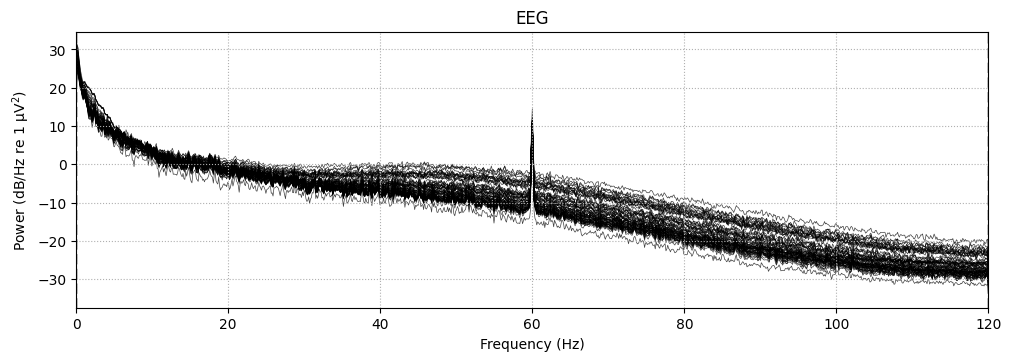

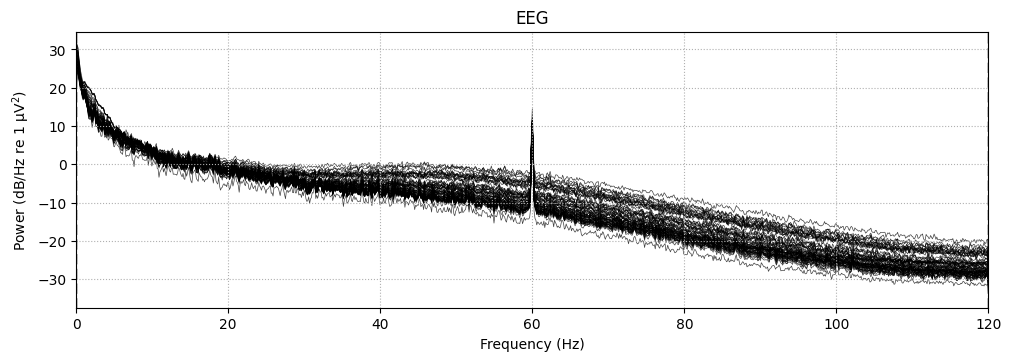

In [34]:
#1) Visualising data:
raw_orig=raw.copy()
psd=raw_orig.compute_psd()
psd.plot()

In [35]:
#2) Applying bandpass filter:
raw.filter(l_freq=0.1,h_freq=20,fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 7921 samples (33.004 s)



<RawArray | 64 x 662490 (2760.4 s), ~323.5 MiB, data loaded>

In [36]:
#3)Downsampling data:
raw.resample(sfreq=120)

<RawArray | 64 x 331245 (2760.4 s), ~161.8 MiB, data loaded>

Effective window size : 17.067 (s)
Plotting power spectral density (dB=True).


/tmp/ipython-input-46976812.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot()


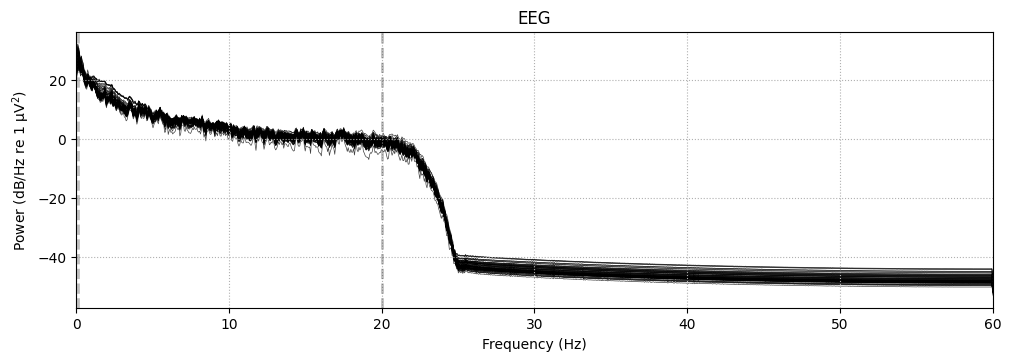

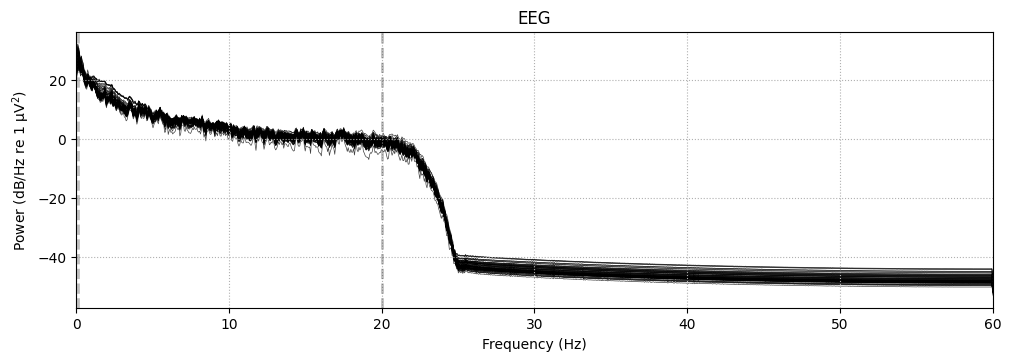

In [37]:
#4)Visualising filtered data
psd=raw.compute_psd()
psd.plot()

In [ ]:
# https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#
# 1. Assign Standard Channel Names and Montage
# The initial channel names might be generic (e.g., EEG_1, EEG_2).
# Rename the EEG channels to standard names (e.g., 'FC5', 'Cz', 'Pz')
# that correspond to a known montage (e.g., 'standard_1005' or 'standard_1020').
# This is crucial for visualizing components topologically.
# Then, set a standard montage using mne.channels.make_standard_montage.

# 2. Initialize and Fit ICA
# Initialize an ICA object (e.g., mne.preprocessing.ICA) specifying parameters like n_components and random_state.
# Then, fit the ICA model to the raw data, often applying a high-pass filter (>1Hz) for better component separation.
# (Example: ica.fit(raw, reject=dict(eeg=...)))

# 3. Plot ICA Components
# After fitting, plot the ICA components to visually inspect them for artifacts like eye blinks or muscle activity.
# (Example: ica.plot_components())


In [42]:
#1)Assigning standard channels names+montage:

#using standard_1020 montage
montage=mne.channels.make_standard_montage('standard_1020')
#now using this to get channels names and renaming:
old_names=raw.ch_names
standard_names=montage.ch_names[:len(old_names)]
rename_dict=dict(zip(old_names,standard_names))
raw.rename_channels(rename_dict)

raw.set_montage(montage)

<RawArray | 64 x 331245 (2760.4 s), ~161.8 MiB, data loaded>

In [47]:
# @title
#2)Initalizing and fitting ICA:
raw_ica=raw.copy()
raw_ica.filter(l_freq=1,h_freq=None)

ica=mne.preprocessing.ICA(n_components=15,random_state=97,max_iter="auto") #I used parameters given in article
ica.fit(raw_ica,reject=dict(eeg=300e-6))

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 397 samples (3.308 s)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF9', 'AF7', 'AF5', 'AF3', 'AF1', 'AFz', 'AF2', 'AF4', 'AF6', 'AF8', 'AF10', 'F9', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'F10', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'T9', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'T10', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P9', 'P7', 'P5', 'P3', 'P1', 'Pz']
Artifact 

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,43 iterations on raw data (328800 samples)
ICA components,15
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


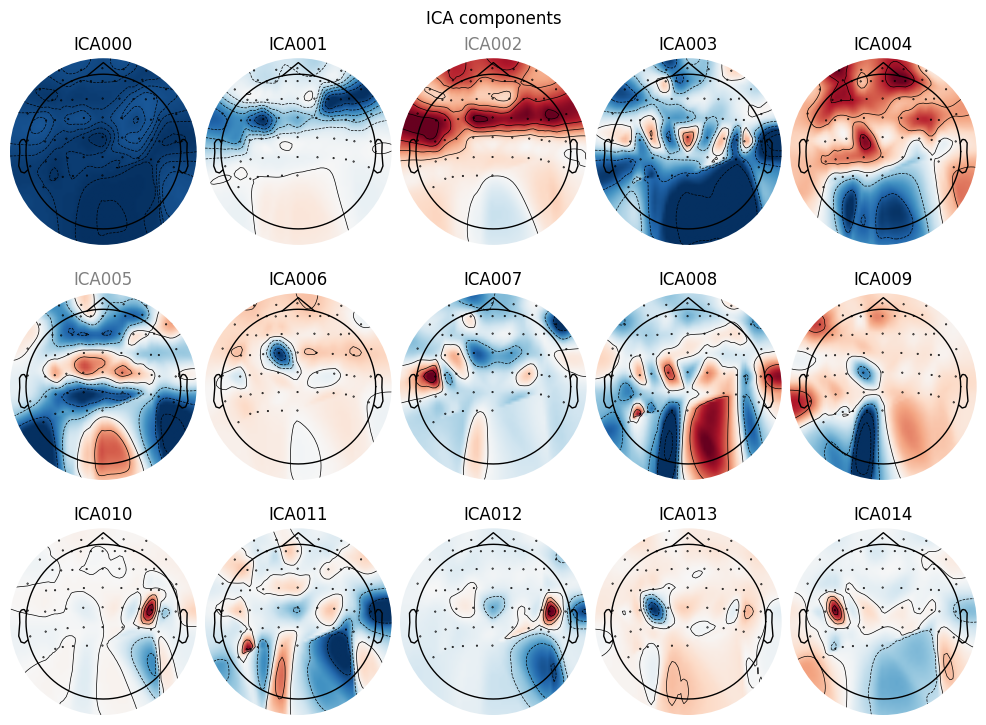

In [87]:
#3)Plotting ICA
ica.plot_components();

In [40]:

# 1. Identify and Exclude Artifact Components
# Based on visual inspection of the ICA components (from the previous step),
# identify components that clearly represent artifacts (e.g., eye blinks, eye movements, muscle activity).
# Then, set the 'exclude' attribute of the ICA object with the indices of these artifact components.

# 2. Apply ICA to Remove Artifacts
# Apply the trained ICA model with the excluded components to the raw data.
# This will project the data back into sensor space with the identified artifact components removed.
# (Example: ica.apply(raw))

# 3. Visualize Clean Data
# To verify the artifact removal, plot a segment of the cleaned raw data.
# Observe if the previously identified artifacts (like large eye blinks) have been successfully suppressed.
# (Example: raw.plot(n_channels=..., duration=..., title='Data AFTER removing Blinks'))


In [50]:
#1)
ica.exclude=[2,5] #case 2 is case of blink most probably, and in 5 its somewhat spread around and uniform hence excluded

In [53]:
#2)
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


<RawArray | 64 x 331245 (2760.4 s), ~161.8 MiB, data loaded>

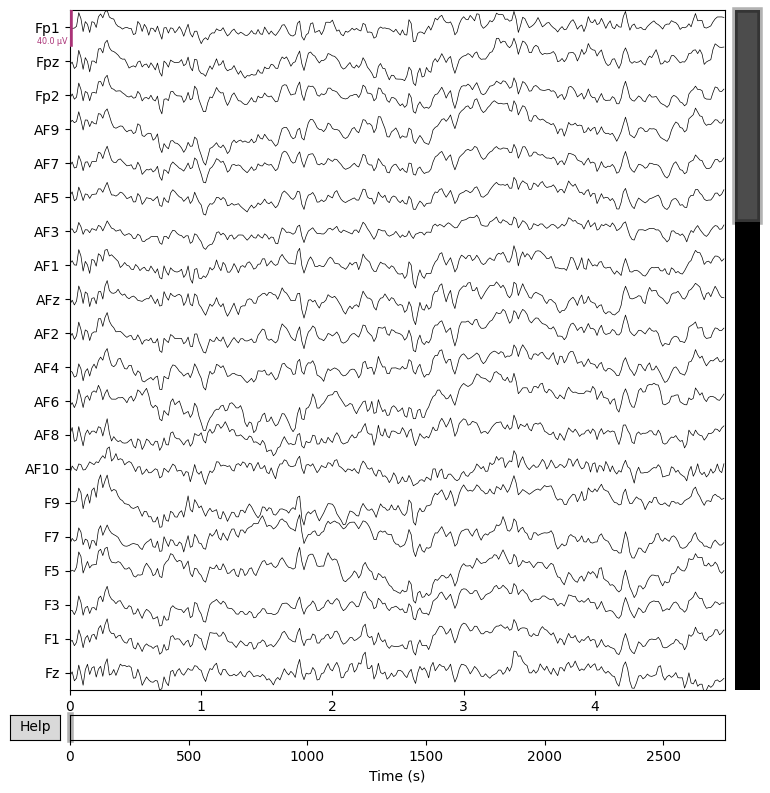

In [58]:
#3)Visualize clean data AFTER ICA

raw.plot(n_channels=20,duration=5,title='Data AFTER removing artifacts');


In [ ]:
# 1. Prepare Events for Epoching
# Load and process the 'StimulusType' data to assign labels (e.g., Target/Non-Target)
# to the event onsets identified earlier. Create a new MNE-compatible events array
# where the third column represents the event ID (e.g., 1 for Non-Target, 2 for Target).
# Ensure the event IDs are integers.

# 2. Define Event IDs Dictionary
# Create a dictionary mapping descriptive event names (e.g., 'Non-Target', 'Target') to their corresponding integer IDs.

# 3. Create Epochs
# Use mne.Epochs to segment the continuous raw data around the events.
# Define the epoch time window (e.g., tmin, tmax), set a baseline correction,
# and preload the data into memory.

# 4. Compute Evoked Responses
# Compute the average evoked potentials for each event type (e.g., 'Target' and 'Non-Target')
# using the epochs object.

# 5. Visualize the P300 Response
# Plot the averaged evoked responses, typically focusing on a central parietal electrode like 'Cz' or 'Pz',
# to look for the characteristic P300 component (a positive deflection around 300ms post-stimulus).
# (Example: mne.viz.plot_compare_evokeds for 'Target' vs 'Non-Target' at 'Cz')



In [70]:
#1)Preparing events for epoching:
stim_type=mat_data['StimulusType']
stim_type_concat=np.concatenate(stim_type,axis=0)
stim_type_flat=stim_type_concat.flatten()

events_new=events.copy()
events_new=events_new.astype(int)
for i in range(len(events_new)):
  if stim_type_flat[i]==1:
    events_new[i,2]=2
  else:
    events_new[i,2]=1

In [71]:
#2)Defining events Id dic:
event_id={
    'Non-Target':1,
    'Target':2
}

In [72]:
#3) Creating epochs:

epochs=mne.Epochs(
    raw,
    events_new,
    event_id=event_id,
    tmin=-0.2,
    tmax=0.8,
    baseline=(None,0),
    preload=True
)

#as we can see nearly 50% of epochs were dropped

Not setting metadata
15299 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15299 events and 121 original time points ...
7649 bad epochs dropped


In [73]:
#4)Computing evoked responses
evoked_target=epochs['Target'].average()
evoked_nontarget=epochs['Non-Target'].average()

combining channels using "mean"
combining channels using "mean"


/tmp/ipython-input-4199897515.py:3: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


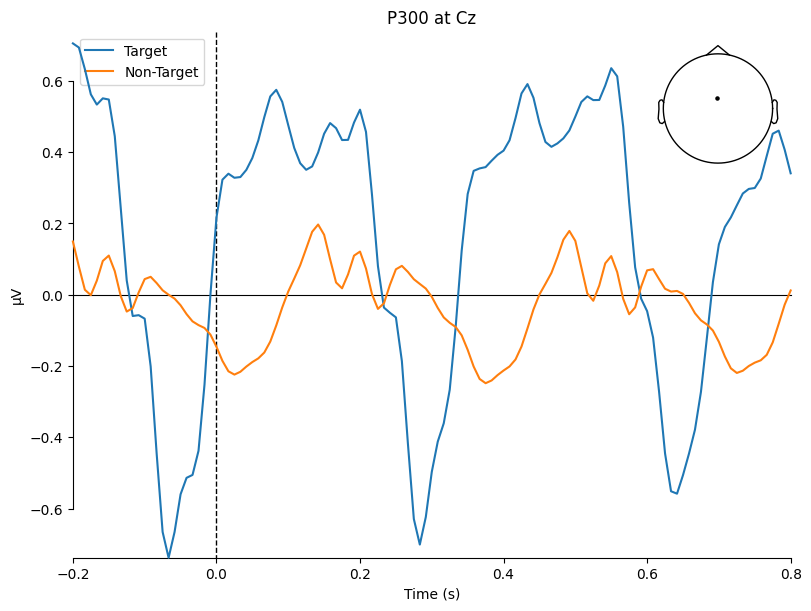

[<Figure size 800x600 with 2 Axes>]

In [85]:
#5)Visualizing P300 at Cz

mne.viz.plot_compare_evokeds(
    {'Target':evoked_target,'Non-Target':evoked_nontarget},
    picks='Cz',
    combine='mean',
    title='P300 at Cz'
)

#We can indeed see positive deflection occuring after 300 ms, its slightly delayed but its there

In [ ]:

# 1. Compare Evokeds at Pz
# In addition to Cz, plot the evoked responses at channel 'Pz' (Parietal-central)
# as the P300 component is often prominently observed there.
# (Example: mne.viz.plot_compare_evokeds for 'Target' vs 'Non-Target' at 'Pz')



combining channels using "mean"
combining channels using "mean"


/tmp/ipython-input-2909460208.py:2: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


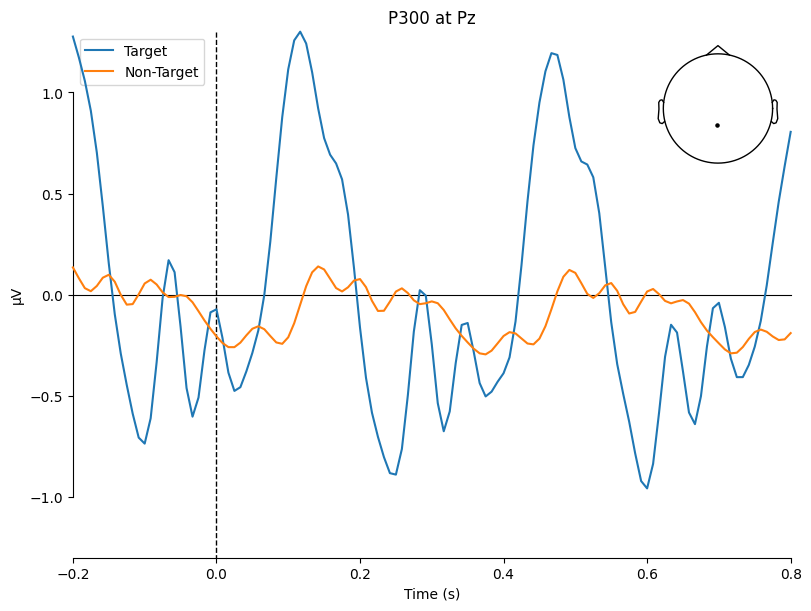

[<Figure size 800x600 with 2 Axes>]

In [86]:
#1)Comparing evoked responses at Pz
mne.viz.plot_compare_evokeds(
    {'Target':evoked_target,'Non-Target':evoked_nontarget},
    picks='Pz',
    combine='mean',
    title='P300 at Pz'
)

#Here also deflection is slightly delayed from usual 300ms but its there